In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

import pickle as pk
from PIL import Image
import random

PyTorch Version:  1.0.0
Torchvision Version:  0.2.1


In [2]:
# Detect if we have a GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:',device)

batch_size = 64

device: cuda


## 读取数据

In [5]:
from torch.utils.data import Dataset, DataLoader
def dataLoader():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # mean = [0.485, 0.456, 0.406]  std = [0.229, 0.224, 0.225]
    test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])
    Gallery_dataset = datasets.ImageFolder(root='../数据集/Google dataset of SIRI-WHU_earth_im_tiff/data/test', transform=test_augs)
    return Gallery_dataset
Gallery_dataset = dataLoader()
Gallery_loader = DataLoader(Gallery_dataset,
                           batch_size = 32, shuffle=False)

In [6]:
len(Gallery_loader) # 32*15

15

## 加载预训练的网络

In [7]:
## 加载模型：resnet34_whurisi_remote_finetune_
pretrained_net = models.resnet34(pretrained=True)
# pretrained_net.fc = nn.Linear(512, 10)
pretrained_net.fc = nn.Linear(512, 12)
PATH = "./my_model/remote_resnet34_fine-tune.pt"
pretrained_net.fc = nn.Sequential()
pretrained_net.load_state_dict(torch.load(PATH))

In [10]:
# pretrained_net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [8]:
pretrained_net = pretrained_net.to(device)

## 提取特征，并保持至本地

In [9]:
# save to loacl file
save_path = './features/remote12-train-resnet'

def save_data(file, data):
    f = open(file, 'wb+')
    pk.dump(data, f, 0)
    f.close()


def extract_features(model, loader):
    since = time.time()
    features = torch.FloatTensor()
         
    model.eval()

    # Iterate over data.
    for inputs, labels in loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        ff = outputs.data.cpu()
        # norm feature
        fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
        ff = ff.div(fnorm.expand_as(ff))
        features = torch.cat((features, ff), 0)

    time_elapsed = time.time() - since
    print('Feature extraction complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return features

if os.path.exists(save_path):
    fo = open(save_path, 'rb')
    features = pk.load(fo, encoding='bytes')
    fo.close()
    print("Load features.")
else:
    features = extract_features(pretrained_net, Gallery_loader)
    save_data(save_path, features)
    print("Save features to %s" % (save_path))

Feature extraction complete in 0m 29s
Save features to ./features/remote12-train-resnet


In [12]:
features[0].shape

torch.Size([512])

## 几个辅助函数

In [48]:
# 封装距离比较函数
def similarity_of_two(img_data1, img_data2):
    out = (img_data1*img_data2)
    return out.sum()

# 计算目标图片与数据库中每张图像的余弦相似度
def search_similar(target, features):
    record = []
    for i in range(len(features)):
        record.append(similarity_of_two(target, features[i]) )
    return record

In [49]:
similarity_of_two(features[0], features[1])

tensor(0.8303)

## 提取查询图像特征

In [50]:
# 提取目标图像的特征  修
def query_feature(input):
    x = input

    x = x.unsqueeze(dim=0)
    x.requires_grad = False

    x.to(device)
    pretrained_net.to('cpu')
    pretrained_net.eval()
    
    pre = pretrained_net(x)
    pre = pre.data.cpu()
    # norm feature
    prenorm = torch.norm(pre, p=2, dim=1, keepdim=True)
    pre = pre.div(prenorm.expand_as(pre))
    return pre


## 图像展示

In [51]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def tensor2image(data):
    # 因为做了归一化，要返回标准tensor
    for i in range(len(data)): # (x-m)/s = y   x = 
        data[i] = data[i] * std[i] + mean[i]
    img = transforms.ToPILImage()(data).convert('RGB')
    plt.imshow(img)

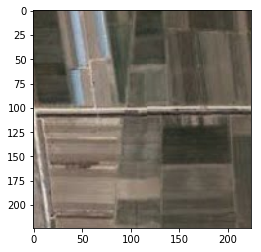

In [52]:
tensor2image(Gallery_dataset[0][0])

In [53]:
len(Gallery_dataset)

480

## 图像搜索

target label: 8
found label : 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 10 8 8 8 8 8 10 8 8 8 8 8 10 8 8 10 10 8 10 8 10 8 8 8 

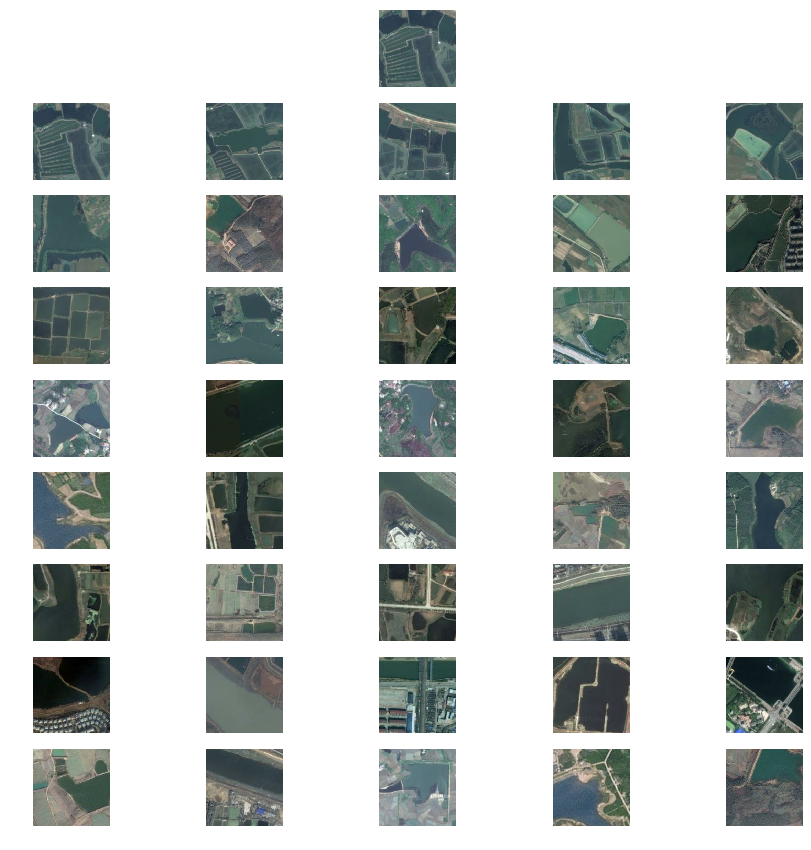

In [87]:
# for _ in range(3): # 搜三张试试吧
k = 320  # 480张图中随机选一张测试
plt.subplots(figsize=(15, 15))
print("target label:",Gallery_dataset[k][1])
plt.subplot(953)
tensor2image(Gallery_dataset[k][0])
plt.axis('off')

pre = query_feature(Gallery_dataset[k][0])
res = search_similar(pre, features)
sim = np.argsort(res)[-40:]  # 取最相似的５张

preLabelList = []
i = 6
print('found label : ',end='')
for index in range(len(sim)):
    re = sim[len(sim)-1-index]
    plt.subplot(9, 5, i)      
    tensor2image(Gallery_dataset[re][0])
    print('%s ' % (Gallery_dataset[re][1]),end='')
    preLabelList.append(Gallery_dataset[re][1])
    i += 1
    plt.axis('off')
plt.show()

In [84]:
Gallery_dataset[0][1]

0

In [70]:
preLabelList

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 9,
 4,
 10,
 4,
 4,
 4,
 4]

In [79]:
def compute_AP(list, label):
    true_size = 0.0
    mAP = 0.0
    for i in range(len(list)):
        if list[i] == label:
            true_size += 1.
            mAP += true_size / (i+1)
    return mAP/true_size
compute_mAP(preLabelList, Gallery_dataset[k][1])

0.8860301978401017

##  计算mAP

In [82]:
sum_AP = 0.0
for _ in range(20): # 搜三张试试吧
    k = random.randint(0, len(Gallery_dataset))  # 480张图中随机选一张测试
    # plt.subplots(figsize=(15, 15))
    # print("target label:",Gallery_dataset[k][1])
    # plt.subplot(953)
    # tensor2image(Gallery_dataset[k][0])
    # plt.axis('off')

    pre = query_feature(Gallery_dataset[k][0])
    res = search_similar(pre, features)
    sim = np.argsort(res)[-40:]  # 取最相似的５张

    preLabelList = []
    i = 6
#     print('found label : ',end='')
    for index in range(len(sim)):
        re = sim[len(sim)-1-index]
#         plt.subplot(9, 5, i)      
#         tensor2image(Gallery_dataset[re][0])
#         print('%s ' % (Gallery_dataset[re][1]),end='')
        preLabelList.append(Gallery_dataset[re][1])
#         i += 1
#         plt.axis('off')
#     plt.show()
    AP = compute_AP(preLabelList, Gallery_dataset[k][1])
    print('label: ', Gallery_dataset[re][1], 'AP: ', AP)
    sum_AP += AP
mAP = sum_AP / 20

label:  9 AP:  0.9898002487592268
label:  10 AP:  0.9946763068538093
label:  8 AP:  0.7682868635537811
label:  5 AP:  0.9992492492492493
label:  8 AP:  0.9579603283538741
label:  2 AP:  0.9697168384373888
label:  3 AP:  0.9791902381128591
label:  1 AP:  0.9923952627866289
label:  11 AP:  0.9765156813630316
label:  2 AP:  0.9992492492492493
label:  9 AP:  0.9951347483795684
label:  6 AP:  0.9070242430234682
label:  10 AP:  0.9233958273435682
label:  9 AP:  0.8325035229676513
label:  1 AP:  0.9971327876733282
label:  6 AP:  0.9987015121630506
label:  8 AP:  0.997191523507313
label:  6 AP:  0.9993589743589744
label:  1 AP:  1.0
label:  7 AP:  0.9979729729729729


In [81]:
sum_AP

0.9792186106300761

In [ ]:
k = random.randint(0, len(Gallery_dataset))  # 480张图中随机选一张测试
    
    print("target label:",Gallery_dataset[k][1])
    plt.subplot(253)
    tensor2image(Gallery_dataset[k][0])
    plt.axis('off')
    
    pre = query_feature(Gallery_dataset[k][0])
    res = search_similar(pre, features)
    sim = np.argsort(res)[-5:]  # 取最相似的５张

    i = 6
    print('found label : ',end='')
    for re in sim:
        plt.subplot(2, 5, i)      
        tensor2image(Gallery_dataset[re][0])
        print('%s ' % (Gallery_dataset[re][1]),end='')
        i += 1
        plt.axis('off')
    plt.show()

In [37]:
k = random.randint(0, len(Gallery_dataset))  # 480张图中随机选一张测试
k

34

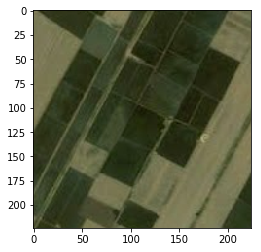

In [38]:
tensor2image(Gallery_dataset[k][0])

In [39]:
pre = query_feature(Gallery_dataset[k][0])

In [41]:
res = search_similar(pre, features)

In [44]:
similarity_of_two(features[0],features[0] )

tensor(1.)